In [168]:
%matplotlib inline
import importlib
import utils2; importlib.reload(utils2)
from utils2 import *

In [169]:
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
from keras import metrics
from vgg16_avg import VGG16_Avg
import os

In [170]:
limit_mem()

In [171]:
current_dir = os.getcwd(); current_dir

'/home/ubuntu/courses/deeplearning2'

In [172]:
path = current_dir + '/data/upsample/'

In [173]:
spath = current_dir + '/data/ls8NeuralTrans/'

### Preprocessing

In [174]:
#get content image
rn_mean = np.array([123.68, 116.779, 103.939],dtype=np.float32)
preproc = lambda x : (x - rn_mean)[:,:,:,::-1]

###### Testing preproc

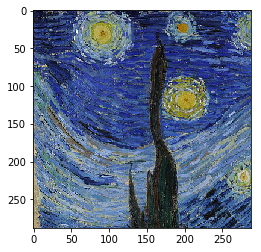

In [175]:
Style = Image.open(spath + 'starry_night.jpg')
style = Style.resize(np.divide(Style.size,1.5).astype('int32'));
style = np.array(style)[:shp[0],:shp[1],:shp[2]]
style.shape
plt.imshow(style)

In [178]:
arr_hr = bcolz.open(path + 'trn_resized_288.bc')

In [179]:
arr_hr.shape

(19439, 288, 288, 3)

In [180]:
shp = arr_hr.shape[1:];shp

(288, 288, 3)

In [181]:
class ReflectionPadding2D(Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        self.input_spec = [InputSpec(ndim=4)]
        super(ReflectionPadding2D, self).__init__(**kwargs)
        
    def get_output_shape_for(self, s):
        return (s[0], s[1] + 2 * self.padding[0], s[2] + 2 * self.padding[1], s[3])

    def call(self, x, mask=None):
        w_pad,h_pad = self.padding
        return tf.pad(x, [[0,0], [h_pad,h_pad], [w_pad,w_pad], [0,0] ], 'REFLECT')

In [182]:
def conv_block(x,filters,size,stride=(1,1),mode='same',act=True):
    x = Conv2D(filters,size,size,subsample=stride,border_mode= mode)(x)
    x = BatchNormalization()(x)
    return Activation('relu')(x) if act else x

In [183]:
from keras.layers.merge import Concatenate

In [184]:
def res_block(inp,nf):
    x = conv_block(inp,nf,3,mode='valid')
    x = conv_block(x,nf,3,mode='valid')
    inp = Lambda(lambda x : x[:,2:-2,2:-2,:])(inp)
    return merge([inp,x], mode='sum')

In [298]:
def deconv_block(x, filters, size,shape,stride=(2,2)):
    x = Deconv2D(filters, (size, size),subsample=(2,2),
        padding='valid',output_shape=(None,)+shape)(x)  
    x = BatchNormalization()(x)
    print(x.shape)
    return Activation('relu')(x)

In [299]:
def up_block(x,filters,size):
    x = Conv2D(filters,size,size,border_mode='same')(x)
    x = keras.layers.UpSampling2D((2,2))(x)
    x = BatchNormalization()(x)
    return Activation('relu')(x)

In [311]:
inp = Input(shp)
print(inp.shape)
x = ReflectionPadding2D((40,40))(inp)
x = conv_block(x,64,9)
x = conv_block(x,64,3,(2,2))
x = conv_block (x,64,3,(2,2))
print(x.shape)
for i in range(5):
    x= res_block(x,64)
    print(x.shape)
x=up_block(x, 64, 3)
x=up_block(x, 64, 3)
print(x.shape)
x = Conv2D(3,(9,9),activation='tanh',padding='same')(x)
outp = Lambda(lambda x : (x+1)*127.5)(x)



               

(?, 288, 288, 3)
(?, 92, 92, 64)
(?, 88, 88, 64)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/engine/topology.py:624: UserWarning: Class `__main__.ReflectionPadding2D` defines `get_output_shape_for` but does not override `compute_output_shape`. If this is a Keras 1 layer, please implement `compute_output_shape` to support Keras 2.
  tensor_indices=tensor_indices,
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (9, 9), strides=(1, 1), padding="same")`
  
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), strides=(2, 2), padding="same")`
  
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), strides=(1, 1), padding="valid")`
  
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: The `mer

(?, 84, 84, 64)
(?, 80, 80, 64)
(?, 76, 76, 64)
(?, 72, 72, 64)
(?, 208, 208, 64)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same")`
  


In [312]:
outp.shape

TensorShape([Dimension(None), Dimension(208), Dimension(208), Dimension(3)])

In [313]:
vgg_in = Input(shp)
vgg = VGG16(include_top =False, input_tensor = Lambda(preproc)(vgg_in))

In [314]:
for l in vgg.layers:l.trainable=False

In [315]:
def get_output(m,l): return m.get_layer(f'block{l}_conv2').output

In [316]:
vgg_f = Model(vgg_in,[get_output(vgg,o) for o in [1,2,3]])

In [317]:
vgg_c = vgg_f(vgg_in)
vgg_s = vgg_f(outp)

In [318]:
vgg_f.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_76 (InputLayer)        (None, 288, 288, 3)       0         
_________________________________________________________________
lambda_407 (Lambda)          (None, 288, 288, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 288, 288, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 288, 288, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 144, 144, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 144, 144, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 144, 144, 128)     147584    
__________

In [319]:
def mean_sqr_b(diff):
    dims = list(range(1,K.ndim(diff)))
    return K.expand_dims(K.sqrt(K.mean(diff**2,dims)),0)

In [320]:
style_targs = [K.variable(o) for o in vgg_f.predict(np.expand_dims(style,0))]

In [321]:
K.shape(arr_hr[1])

<tf.Tensor 'Shape_33:0' shape=(3,) dtype=int32>

In [322]:
[K.eval(K.shape(o)) for o in style_targs]

[array([  1, 288, 288,  64], dtype=int32),
 array([  1, 144, 144, 128], dtype=int32),
 array([  1,  72,  72, 256], dtype=int32)]

In [323]:
def gram_matrix(x):
    x= K.permute_dimensions(x,(0,3,1,2))
    s = K.shape(x)
    feat = K.reshape(x, (s[0],s[1],s[2]*s[3]))
    return K.batch_dot(feat,K.transpose(feat))/K.prod(K.cast(s[1:],K.floatx()))


In [324]:
w = [0.1,0.2,0.6,0.1]
def tot_loss(x):
    loss = 0; n = len(style_targs)
    for i in range(n):
         loss += mean_sqr_b(gram_matrix(x[i+n]- gram_matrix(style_targs[i])))/2.
         loss += mean_sqr_b(x[i]-x[i+n]) * w[i]   
        
    return loss
    

In [325]:
loss = Lambda(tot_loss)(vgg_c + vgg_s)
m_style = Model([inp,vgg_in],loss)
targ = np.zeros((arr_hr.shape[0],1))

ValueError: Dimensions must be equal, but are 288 and 208 for 'lambda_408/sub_1' (op: 'Sub') with input shapes: [?,288,288,64], [?,208,208,64].

In [ ]:
m_style.compile('adam', 'mae')
m_style.fit([arr_hr, arr_hr], targ,)